# Comparing axis-aligned random forest versus oblique forest on simulation datasets
The previous notebook conducted visual analysis using `Iris` dataset. Here we extend our analysis using custom simulation dataset: `sparse_parity`, from which OF demonstrates significant performance improvement over RF. Additionally, we prepared two toy datasets from scikit-learn dataset module, `make_hastie_10_2` and `make_gaussain_quantiles`, that also simulates high-dimentionality problems. OF also outperforms RF on these datasets but in lesser degree.

## Environment
- Python 3.8.13
- [Sklearn-Adam's dev branch](https://github.com/neurodata/scikit-learn/tree/obliquepr)

In [1]:
!python --version

Python 3.8.13


## Import packages

In [2]:
import sklearn
from sklearn.ensemble import RandomForestClassifier, ObliqueRandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_hastie_10_2, make_gaussian_quantiles #imported additionally in case of testing
from sklearn.model_selection import RepeatedKFold, cross_validate

from datetime import datetime
from tqdm import tqdm
import itertools
import os
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

random_state = 123456

sklearn.__version__

'1.2.dev0'

In [3]:
today = str(datetime.now().date())
today

'2022-06-10'

#### Generating sparse parity simulation data
Sparse parity is a variation of the noisy parity problem, which itself is a multivariate generalization of the noisy XOR problem. This is a binary classification task in high dimensions. 

In [4]:
def sparse_parity(n_samples, p=20, p_star=3, noise=None, random_seed=None, **kwarg):
 
    if random_seed: 
        np.random.seed(random_seed)

    X = np.random.uniform(-1, 1, (n_samples, p))
    y = np.zeros(n_samples)

    for i in range(0, n_samples):
        y[i] = sum(X[i, :p_star] > 0) % 2;

    return X, y

In [5]:
def get_sample(func, n, m=None, o=None):
    k = {}

    np.random.seed(random_state)

    if m: k['noise'] = m
    if o: k['n_features'] = o

    k['n_samples'] = n
    k['random_state'] = random_state # random_state for classifiers

    X, y = func(**k)

    return X, y

def get_scores(X, y, max_features, max_depth, random_state, n_cv, n_repeats):

    clfs = [
        RandomForestClassifier(max_features=max_features, max_depth=max_depth, random_state=random_state),
        ObliqueRandomForestClassifier(max_features=max_features, max_depth=max_depth, random_state=random_state)
    ]

    tmp = []

    for i, clf in enumerate(clfs):

        if i == 0 and isinstance(max_features, int):
            if max_features > X.shape[1]:
                tmp.append(np.zeros(n_cv * n_repeats))
                continue

        cv = RepeatedKFold(n_splits=n_cv, n_repeats=n_repeats, random_state=random_state)
        test_score = cross_validate(estimator=clf, X=X, y=y, cv=cv, scoring='accuracy')
        
        tmp.append(
            test_score['test_score']
        )

    # print(f'max_feature: {max_features} | max_depth: {max_depth}')

    return tmp

In [35]:
X1,y1 = sparse_parity(n_samples=500,p=2) #p set to 2 for illustration purpose
X2,y2 = sparse_parity(n_samples=5000,p=3) #p set to 2 for illustration purpose
X1.shape, y1.shape, X2.shape, y2.shape

((500, 2), (500,), (5000, 3), (5000,))

#### Visualization of sparse parity at low dimention
At `p=2`, sparse partiy becomes noisy XOR problem. As 



- describe sparse parity as done in the paper in more laymen terms
- describe the intuition for why OF would be better than RF

e.g. OF should be more robust to high-dimensional noise. Moreover, due to the ability to sample more variable splits (i.e. `max_features` can be greater than `n_features` compared to RF), then we expect to see an increase in performance when we are willing to use computational power to sample more splits.

Ref for sparse parity: https://epubs.siam.org/doi/epdf/10.1137/1.9781611974973.56

Text(0.5, 0.92, 'Sparse Parity')

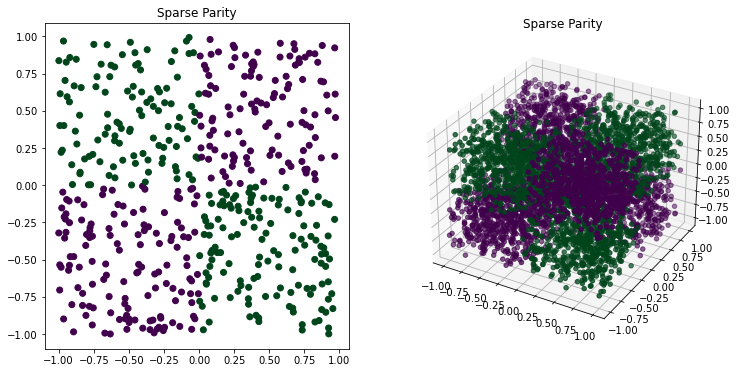

In [37]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.scatter(X1[:,0],X1[:,1], c=y1, cmap='PRGn')
ax.set_title('Sparse Parity')

ax = fig.add_subplot(122, projection='3d')
ax.scatter(X2[:,0],X2[:,1],X2[:,2], c=y2, cmap='PRGn')
ax.set_title('Sparse Parity')

In [8]:
def run_experiment(n_repeat, n_cv, random_state):
    n_samples = [100, 1000, 10000]
    accs = []
    
    clf_kwarg = {
        'max_features': None,
        'max_depth': 10,
        'random_state': random_state,
        'n_repeats': n_repeat,
        'n_cv': n_cv
    }

    for n_sample in tqdm(n_samples):
        data_args = [
            # name of dataset, function, n_sample, noise, n_features
            ['sparse_parity', sparse_parity, n_sample]
            # ['make_gaussian_quantiles', make_gaussian_quantiles, n_sample, None, 5],
            # ['make_hastie_10_2', make_hastie_10_2, n_sample]
        ]

        for arg in data_args:
            X, y = get_sample(*arg[1:])
            
            for max_feature in ['sqrt', X.shape[1], X.shape[1]*2]: #max_features
                clf_kwarg['max_features'] = max_feature

                acc = get_scores(X, y, **clf_kwarg)
                accs.append([arg[0], n_sample, n_repeat, max_feature, clf_kwarg['max_depth'], random_state] + acc)

    df = pd.DataFrame(accs, columns=['dataset', 'n_sample', 'n_repeat', 'max_feature', 'max_depth', 'random_state', 'RF', 'OF'])
    df['delta'] = df.apply(lambda x: x.OF-x.RF, axis=1)

    # with open('dat/simulation_notebook_rf_vs_of.pkl', 'wb') as f:
    #     pickle.dump(df, f, protocol=pickle.HIGHEST_PROTOCOL)

    return df

In [9]:
df = run_experiment(n_repeat=1, n_cv=3, random_state=random_state)

100%|██████████| 3/3 [01:07<00:00, 22.48s/it]


In [10]:
df2 = df.copy()
df2['max_depth'] = df2.max_depth.replace(np.nan, 'inf')
df2 = df2.explode(['RF','OF','delta'])[['dataset','n_sample','max_feature','max_depth','RF','OF','delta']]
df2.head()

,dataset,n_sample,max_feature,max_depth,RF,OF,delta
0,sparse_parity,100,sqrt,10,0.441176,0.411765,-0.029412
0,sparse_parity,100,sqrt,10,0.363636,0.424242,0.060606
0,sparse_parity,100,sqrt,10,0.333333,0.424242,0.090909
1,sparse_parity,100,20,10,0.323529,0.294118,-0.029412
1,sparse_parity,100,20,10,0.424242,0.363636,-0.060606


In [11]:
dset = df2.dataset.unique()
df2 = df2.copy()
max_depth = 10

for i, d in enumerate(dset):
    df_new = df2.query(f'dataset == "{d}" and max_depth == {max_depth}')
    n_feature = df_new[~(df_new.max_feature == 'sqrt')].max_feature.min() #minimum numeric max_feature

    df_mf1 = df_new.query(f'max_feature == {n_feature}') #RF max_feature to be compared with OF 2x, 3x max_feature

    for ns in df_mf1.n_sample.unique(): #n_sample
        for mf_not_1 in df_new.max_feature.unique():
            if mf_not_1 in [n_feature, 'sqrt']:
                continue

            indexing = (df2.dataset==d) & (df2.max_depth==max_depth) & (df2.n_sample==ns) & (df2.max_feature==mf_not_1)
            df2.loc[indexing, ['RF']] = df_mf1.query(f'n_sample == {ns}').RF.tolist()

df2['delta'] = df2.apply(lambda x: x.OF-x.RF, axis=1)

In [12]:
df2.head()

,dataset,n_sample,max_feature,max_depth,RF,OF,delta
0,sparse_parity,100,sqrt,10,0.441176,0.411765,-0.029412
0,sparse_parity,100,sqrt,10,0.363636,0.424242,0.060606
0,sparse_parity,100,sqrt,10,0.333333,0.424242,0.090909
1,sparse_parity,100,20,10,0.323529,0.294118,-0.029412
1,sparse_parity,100,20,10,0.424242,0.363636,-0.060606


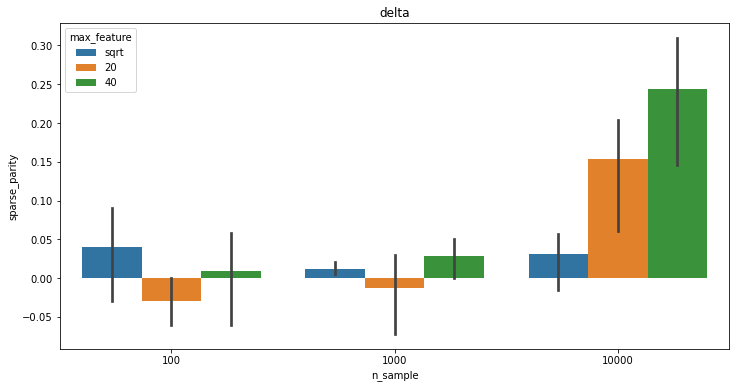

In [13]:
dset = df2.dataset.unique()

fig, ax = plt.subplots(dset.shape[0], 1, figsize=(12,6*dset.shape[0]))

for i, d in enumerate(dset):

    df_new = df2.query(f'dataset == "{d}" and max_depth == {max_depth}')

    sns.barplot(data=df_new, x='n_sample', y='delta', hue='max_feature', ax=ax)

    ax.set_title('delta')
    ax.set_ylabel(f'{d}')

## Appendix

In [14]:
col_groupby = ['dataset','n_sample','max_feature','max_depth']
dff = df2.groupby(col_groupby).mean()
dff.style.background_gradient(cmap='RdBu_r', vmin=-0.4, vmax=0.4)